<table>
    <tr>
        <td><img src='SystemLink_icon.png' /></td>
        <td ><h1><strong>NI SystemLink Python API</strong></h1></td>
    </tr>
</table>

## TDMReader Service Example
***
The TDMReader Service API provides functions to access TDMS data (Groups, Channels, Metadata) in TDMS files hosted by **SystemLink**. The TDMReader Service API uses the file id as a key to locate which file to read. The file id can be retrieved using the File Service API.
***
# Prerequisites
- Before you run this example, you need to create the test file (sine_wave_sdk_example.tdms)
    - To do that, run the FileServiceExample notebook located in the same folder as this file.

# Summary
This example exercises the File Service API to get the file id of the test file created by the FileServiceExample notebook. The file id is then consumed by the TDMReader Service API to read the Sine Waves stored on the file, which have noise. Finally, the waveforms are plotted.

- Get the file id of 'sine_wave_sdk_example.tdms' calling the **query_files** File Service API call
- Get all the channels from group 'signals' on the test file, by calling the **query_data** TDMReader API call
- Plot all the channels
- Plot a waveform with the mean values, visualizing the max/min
***

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from systemlink.fileingestionclient import FileIngestionClient, messages as fileingestion_messages
from systemlink.tdmsreaderclient import TDMSReaderClient, messages as tdmsreader_messages

file_name = 'sine_wave_sdk_example.tdms'
group_name = 'signals'

fileingestionclient = FileIngestionClient(service_name='FileIngestionClient')
tdmsreaderclient = TDMSReaderClient(service_name='TDMSReaderClient')

# Use the File Service API to get the fileid of sine_wave_sdk_example.tdms
equal_op = fileingestion_messages.QueryOperator(fileingestion_messages.QueryOperator.EQUAL)
query = fileingestion_messages.StringQueryEntry('Name', file_name, equal_op)
res = fileingestionclient.query_files(properties_query=[query])

num_files = len(res.available_files)

if num_files == 0:
    raise RuntimeError('You need to run the example notebook FileServiceExample.ipynb to upload the test file needed by this example')
elif num_files > 1:
    raise RuntimeError('You have more than one file in SystemLink named {}, aborting'.format(file_name))
else:
    # Get all the Sine Wave signals inside sine_wave_sdk_example.tdms
    file_id = res.available_files[0].id
    limits = tdmsreader_messages.SkipTakeReturnCount(skip_=0, take_=-1, return_count_=True)
    channels = tdmsreaderclient.get_channels(file_id, group_name, limits)

    sine_waves = []
    for channel_name in channels.names:
        channel_specifier = tdmsreader_messages.OneChannelSpecifier(
            file_id_=file_id,
            group_name_=group_name,
            channel_name_=channel_name)
        
        data_window = tdmsreader_messages.DataWindow(
            xmin_=0,
            xmax_=1000,
            xlog_=False,
            ymin_=0,
            ymax_=1000,
            ylog_=False,
            decimatex_=0,
            decimatey_=0,
            show_points_=False,
            show_lines_=False)
        xy_channels = tdmsreader_messages.XYChannels(
            xchannel_=None,
            ychannels_=[channel_specifier],
            data_window_=data_window)
        channel_spec = tdmsreader_messages.ChannelSpecifications(xy_channels_=[xy_channels])
        sine_wave = tdmsreaderclient.query_data(channel_spec)
        sine_waves.append(np.array(sine_wave.data[0].y[0].numeric_data))

# Sine Wave Visualization

Plot the 10 Sine Waves at the same time. The resulting graph shows how the Sine Waves in the tdms file are very noisy.

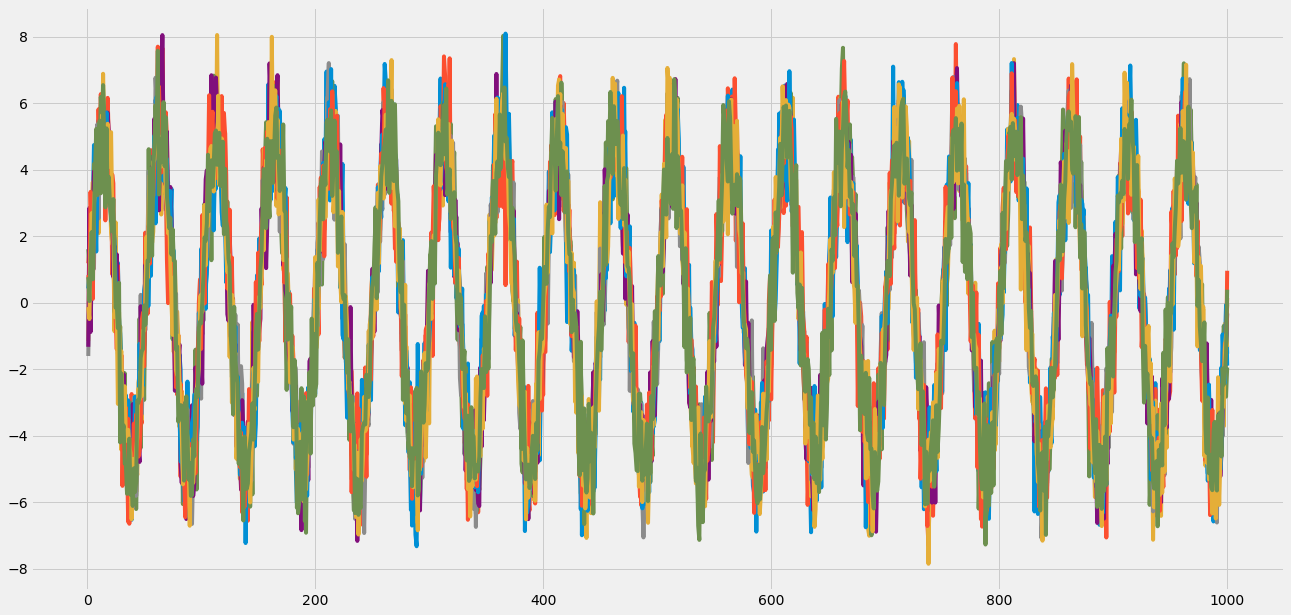

In [13]:
# Plot all the noisy sine waves

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(20, 10))
x = np.linspace(1, 1000, 1000)
for i in range(10):
    plt.plot(x, sine_waves[i])
plt.show()

# Mean Sine Wave with Variance

Next, we calculate the sine wave's mean and plot it. We calculate the max and min values for every point and we plot those too, filling the area between the mean and the min/max. The resulting graph give a richer visualization of the variance between sine wave signals.


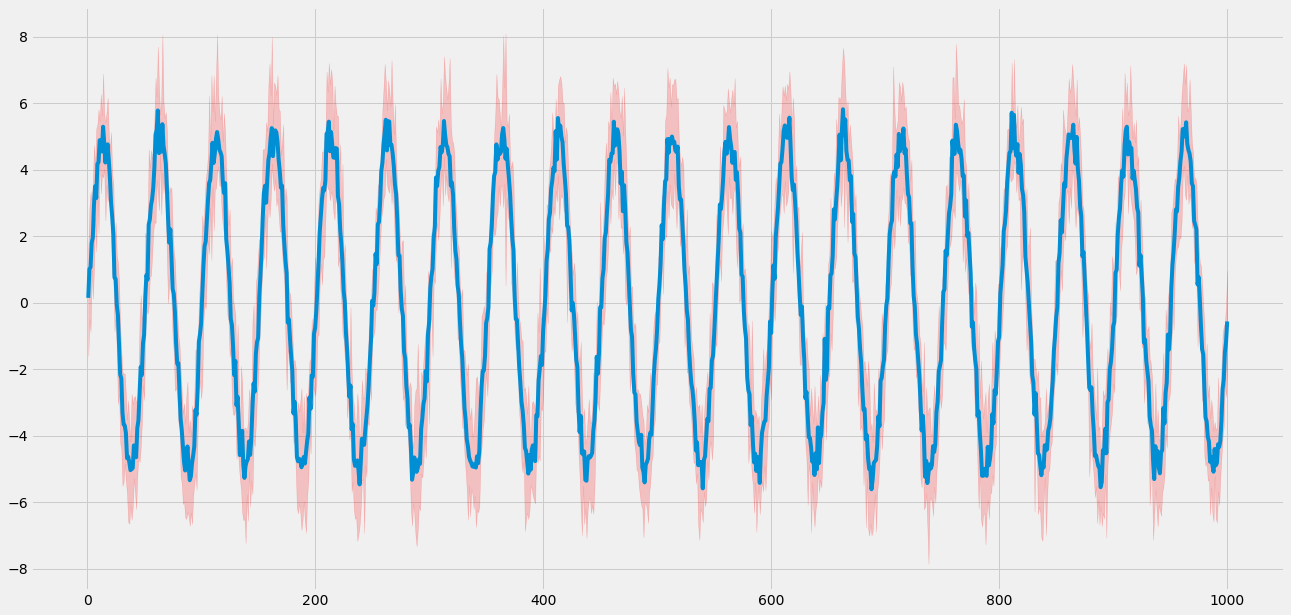

In [14]:
# Plot the sine wave's mean, with the min/max values

mean_sine_wave = np.mean(sine_waves, axis=0)
max_sine_wav = np.max(sine_waves, axis=0)
min_sine_wav = np.min(sine_waves, axis=0)

fig = plt.figure(figsize=(20, 10))
plt.plot(x, mean_sine_wave)
plt.fill_between(x, min_sine_wav, max_sine_wav, color='red', alpha=0.2)
plt.show()